In [1]:
%%capture
! pip install git+https://github.com/DataResponsibly/ShaRP.git

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
from sharp.utils import check_feature_names, scores_to_ordering

from sharp import ShaRP

# Datasets

In [3]:
RNG_SEED = 42
N_SAMPLES = 200
rng = check_random_state(RNG_SEED)

In [4]:
X1 = rng.normal(loc=0, scale=1, size=N_SAMPLES)
Y1 = rng.uniform(low=-1, high=1, size=N_SAMPLES)

In [5]:
data1 = {'X': X1, 'Y': Y1}
df1 = pd.DataFrame(data1)
df1[[x for x in df1.columns]] = MinMaxScaler().fit_transform(df1[[x for x in df1.columns]])

In [6]:
correlation_coefficient = 0.7

Z1 = correlation_coefficient * X1 + rng.normal(loc=0, scale=np.sqrt(1 - correlation_coefficient ** 2), size=N_SAMPLES)

data1_cor = {'X': X1, 'Y': Y1, 'Z': Z1}
df1_cor = pd.DataFrame(data1_cor)
df1_cor[[x for x in df1.columns]] = MinMaxScaler().fit_transform(df1_cor[[x for x in df1.columns]])

In [7]:
X2 = rng.normal(loc=9, scale=16, size=N_SAMPLES)
Y2 = rng.uniform(low=-5, high=6, size=N_SAMPLES)

In [8]:
data2 = {'X': X2, 'Y': Y2}
df2 = pd.DataFrame(data2)
df2[[x for x in df2.columns]] = MinMaxScaler().fit_transform(df2[[x for x in df2.columns]])

In [9]:
correlation_coefficient = 0.7

Z2 = correlation_coefficient * X2 + rng.normal(loc=0, scale=np.sqrt(1 - correlation_coefficient ** 2), size=N_SAMPLES)

data2_cor = {'X': X2, 'Y': Y2, 'Z': Z2}
df2_cor = pd.DataFrame(data2_cor)
df2_cor[[x for x in df2_cor.columns]] = MinMaxScaler().fit_transform(df2_cor[[x for x in df2_cor.columns]])

### Ranking functions

In [10]:
two_vars_equal = {"X": 0.5, "Y": 0.5}

In [11]:
two_vars_non_equal = {"X": 0.7, "Y": 0.3}

In [12]:
three_vars_equal = {"X": 0.33, "Y": 0.33, "Z": 0.33}

In [13]:
three_vars_non_equal = {"X": 0.4, "Y": 0.4, "Z": 0.2}

# Common stuff

In [14]:
def get_score_fun(weights):
    def score_function(row):
        return np.array(row @ weights)

    return score_function

In [15]:
def get_data_by_strata(data, y, contributions, features_names, n_strata=5):
    feature_names = check_feature_names(data)
    df = pd.DataFrame(contributions, columns=feature_names)
    perc_step = 100 / n_strata
    stratum_size = data.shape[0] / n_strata

    df["target"] = scores_to_ordering(y, -1)
    df["target_binned"] = [
        (
            f"0-{int(perc_step)}%"
            if np.floor((rank - 1) / stratum_size) == 0
            else str(int(np.floor((rank - 1) / stratum_size) * perc_step))
                 + "-"
                 + str(int((np.floor((rank - 1) / stratum_size) + 1) * perc_step))
                 + "%"
        )
        for rank in df["target"]
    ]
    df.sort_values(by=["target_binned"], inplace=True)
    df.drop(columns=["target"], inplace=True)

    df["target_binned"] = df["target_binned"].str.replace("<", "$<$")

    bin_names = df["target_binned"].unique()
    result = pd.DataFrame()
    for i, bin_name in enumerate(bin_names):
        strata_data: pd.DataFrame = (
            df[df["target_binned"] == bin_name][feature_names]
            .describe().T
        )

        strata_data['feature'] = features_names
        strata_data['strata'] = bin_name
        result = pd.concat([result, strata_data])
    return result.reset_index(drop=True)

In [16]:
def run_sharp(data, qoi, weights, n_strata):
    scoring_func = get_score_fun(weights)
    xai = ShaRP(
        qoi=qoi,
        target_function=scoring_func,
        measure="shapley",
        sample_size=None,
        replace=False,
        verbose=False,
        n_jobs=-1,
        random_state=RNG_SEED,
    )
    xai.fit(data.values)
    result = get_data_by_strata(
        data.values,
        scoring_func(data.values),
        xai.all(data.values) / len(data),
        data.columns,
        n_strata=n_strata
    )
    return result

In [17]:
def get_stats(data: pd.DataFrame, weights, qoi, n_batches=2, n_strata=5):
    single_batch_result = run_sharp(data, qoi, weights, n_strata=n_strata)
    single_batch_result['batch'] = "NONE"

    batch_len = len(data) // n_batches
    batches = [np.full(len(data) - (batch_len * (n_batches - 1)), 0)]
    for i in range(1, n_batches):
        batches.append(np.full(batch_len, i, dtype=int))
    batches = np.concatenate(batches)
    np.random.shuffle(batches)

    batches_dfs = []
    for i in range(n_batches):
        batch_result = run_sharp(data[batches == i], qoi, weights, n_strata=n_strata)
        batch_result['batch'] = i
        batches_dfs.append(batch_result)

    return pd.concat([single_batch_result] + batches_dfs).reset_index(drop=True)

In [18]:
def get_stats_for_dataset(data, weights, weights_names=None, n_batches=2, n_strata=5):
    if weights_names is None:
        weights_names = ["equal weights", "different weights"]
    final_result = pd.DataFrame()
    for weight_fun, weight_name in zip(weights, weights_names):
        rank_stats = get_stats(data, weight_fun, 'rank', n_batches=n_batches, n_strata=n_strata)
        rank_stats['qoi'] = 'rank'
        rank_score_stats = get_stats(data, weight_fun, 'rank_score', n_batches=n_batches, n_strata=n_strata)
        rank_score_stats['qoi'] = 'rank_score'
        top_k_stats = get_stats(data, weight_fun, 'top_k', n_batches=n_batches, n_strata=n_strata)
        top_k_stats['qoi'] = 'top_k'
        weight_result = pd.concat([rank_stats, rank_score_stats, top_k_stats])
        weight_result['weights'] = weight_name
        final_result = pd.concat([final_result, weight_result])
    return final_result.reset_index(drop=True)

In [19]:
# assign the weights
equal_weights = np.array([0.5, 0.5])
equal_weights_z = np.array([0.5, 0.5, 0])
equal_weights_three = np.array([0.33, 0.33, 0.33])

In [20]:
# assign the weights
different_weights = np.array([0.7, 0.3])
different_weights_z = np.array([0.7, 0.3, 0])
different_weights_three = np.array([0.4, 0.4, 0.2])

# Calculating statistics

In [21]:
std_2vars_stats = get_stats_for_dataset(df1, [equal_weights, different_weights])
std_2vars_stats['data'] = "Standard normal 2 vars"

In [22]:
norm_2vars_stats = get_stats_for_dataset(df2, [equal_weights, different_weights])
norm_2vars_stats['data'] = "Arbitrary normal 2 vars"

In [23]:
std_2vars_z_stats = get_stats_for_dataset(df1_cor, [equal_weights_z, different_weights_z])
std_2vars_z_stats['data'] = "Standard normal 2 vars with correlated third"

In [24]:
norm_2vars_z_stats = get_stats_for_dataset(df2_cor, [equal_weights_z, different_weights_z])
norm_2vars_z_stats['data'] = "Arbitrary normal 2 vars with correlated third"

In [25]:
std_3vars_stats = get_stats_for_dataset(df1_cor, [equal_weights_three, different_weights_three])
std_3vars_stats['data'] = "Standard normal 3 correlated vars"

In [26]:
norm_3vars_stats = get_stats_for_dataset(df2_cor, [equal_weights_three, different_weights_three])
norm_3vars_stats['data'] = "Arbitrary normal 3 correlated vars"

In [27]:
statistics = pd.concat([std_2vars_stats, norm_2vars_stats,
                        std_2vars_z_stats, norm_2vars_z_stats,
                        std_3vars_stats, norm_3vars_stats]).reset_index(drop=True)

In [28]:
statistics['group'] = "NONE"

# Data with groups

In [29]:
# df_grouped_full = pd.read_csv("grouped_data.csv")
# group = df_grouped_full['groups']
# df_grouped = pd.DataFrame()
# df_grouped['X'] = df_grouped_full['f0']
# df_grouped['Y'] = df_grouped_full['f1']

In [30]:
# first_group_stats = get_stats_for_dataset(df_grouped[group == 0], 
#                                           [equal_weights, different_weights])
# first_group_stats['data'] = "Grouped data"
# first_group_stats['group'] = 0

In [31]:
# second_group_stats = get_stats_for_dataset(df_grouped[group == 1],
#                                           [equal_weights, different_weights])
# second_group_stats['data'] = "Grouped data"
# second_group_stats['group'] = 1

In [32]:
# statistics_with_groups = pd.concat([statistics, first_group_stats, second_group_stats])

In [33]:
statistics_with_groups = statistics

# Plots

In [40]:
def plot_experiment(stats, plot_ax, plot_name="", cmap="Pastel1", gap_size=1):
    stats = stats.copy().rename(columns={"min": "whislo", "25%": "q1", "50%": "med",
                                         "75%": "q3", "max": "whishi", "feature": "label"})

    strata_names = stats.index.get_level_values(0).unique()
    feature_names = stats.index.get_level_values(1).unique()
    n_features = len(feature_names)
    position_step = 1 / (n_features + gap_size)
    colors = [plt.get_cmap(cmap)(i) for i in range(n_features)]
    
    handles = []
    for idx, (strata_name, strata_stats) in enumerate(stats.groupby(level=0)):
        boxes = plot_ax.bxp(
            strata_stats.to_dict('records'),
            widths=position_step,
            positions=[idx + position_step * i for i in range(n_features)],
            patch_artist=True,
            showmeans=True,
            meanline=True,
            showfliers=False
        )
        for patch, color in zip(boxes["boxes"], colors):
            patch.set_facecolor(color)
        handles = boxes["boxes"]

    plot_ax.legend(handles, stats.index.get_level_values(1).unique())
    plot_ax.set_xticks(
        np.arange(0, len(strata_names)) + position_step * (n_features - 1) / 2,
    )
    plot_ax.set_xticklabels(strata_names)
    plot_ax.set_title(plot_name)

In [51]:
def plot_statistics(stats, x_axis="weights", y_axis="data",
                    strata_col="strata", feature_col="feature"):
    plt_df = stats.groupby([y_axis, x_axis, strata_col, feature_col]).mean()
    x_values = stats[x_axis].unique()
    y_values = stats[y_axis].unique()
    fig, ax = plt.subplots(nrows=len(y_values), ncols=len(x_values),
                           squeeze=False, figsize=(15, 35))
    for row, y_val in enumerate(y_values):
        y_val_df = plt_df.loc[y_val]
        for col, x_val in enumerate(x_values):
            plot_experiment(y_val_df.loc[x_val], ax[row, col],
                            plot_name=f"{y_val}, {x_val}")
    return fig

In [49]:
plot_df = statistics.copy()
plot_df.loc[plot_df['batch'] != "NONE", "feature"] += " batched"
plot_df = plot_df[plot_df['qoi'] == 'rank']
plot_df = plot_df[plot_df['group'] == 'NONE']

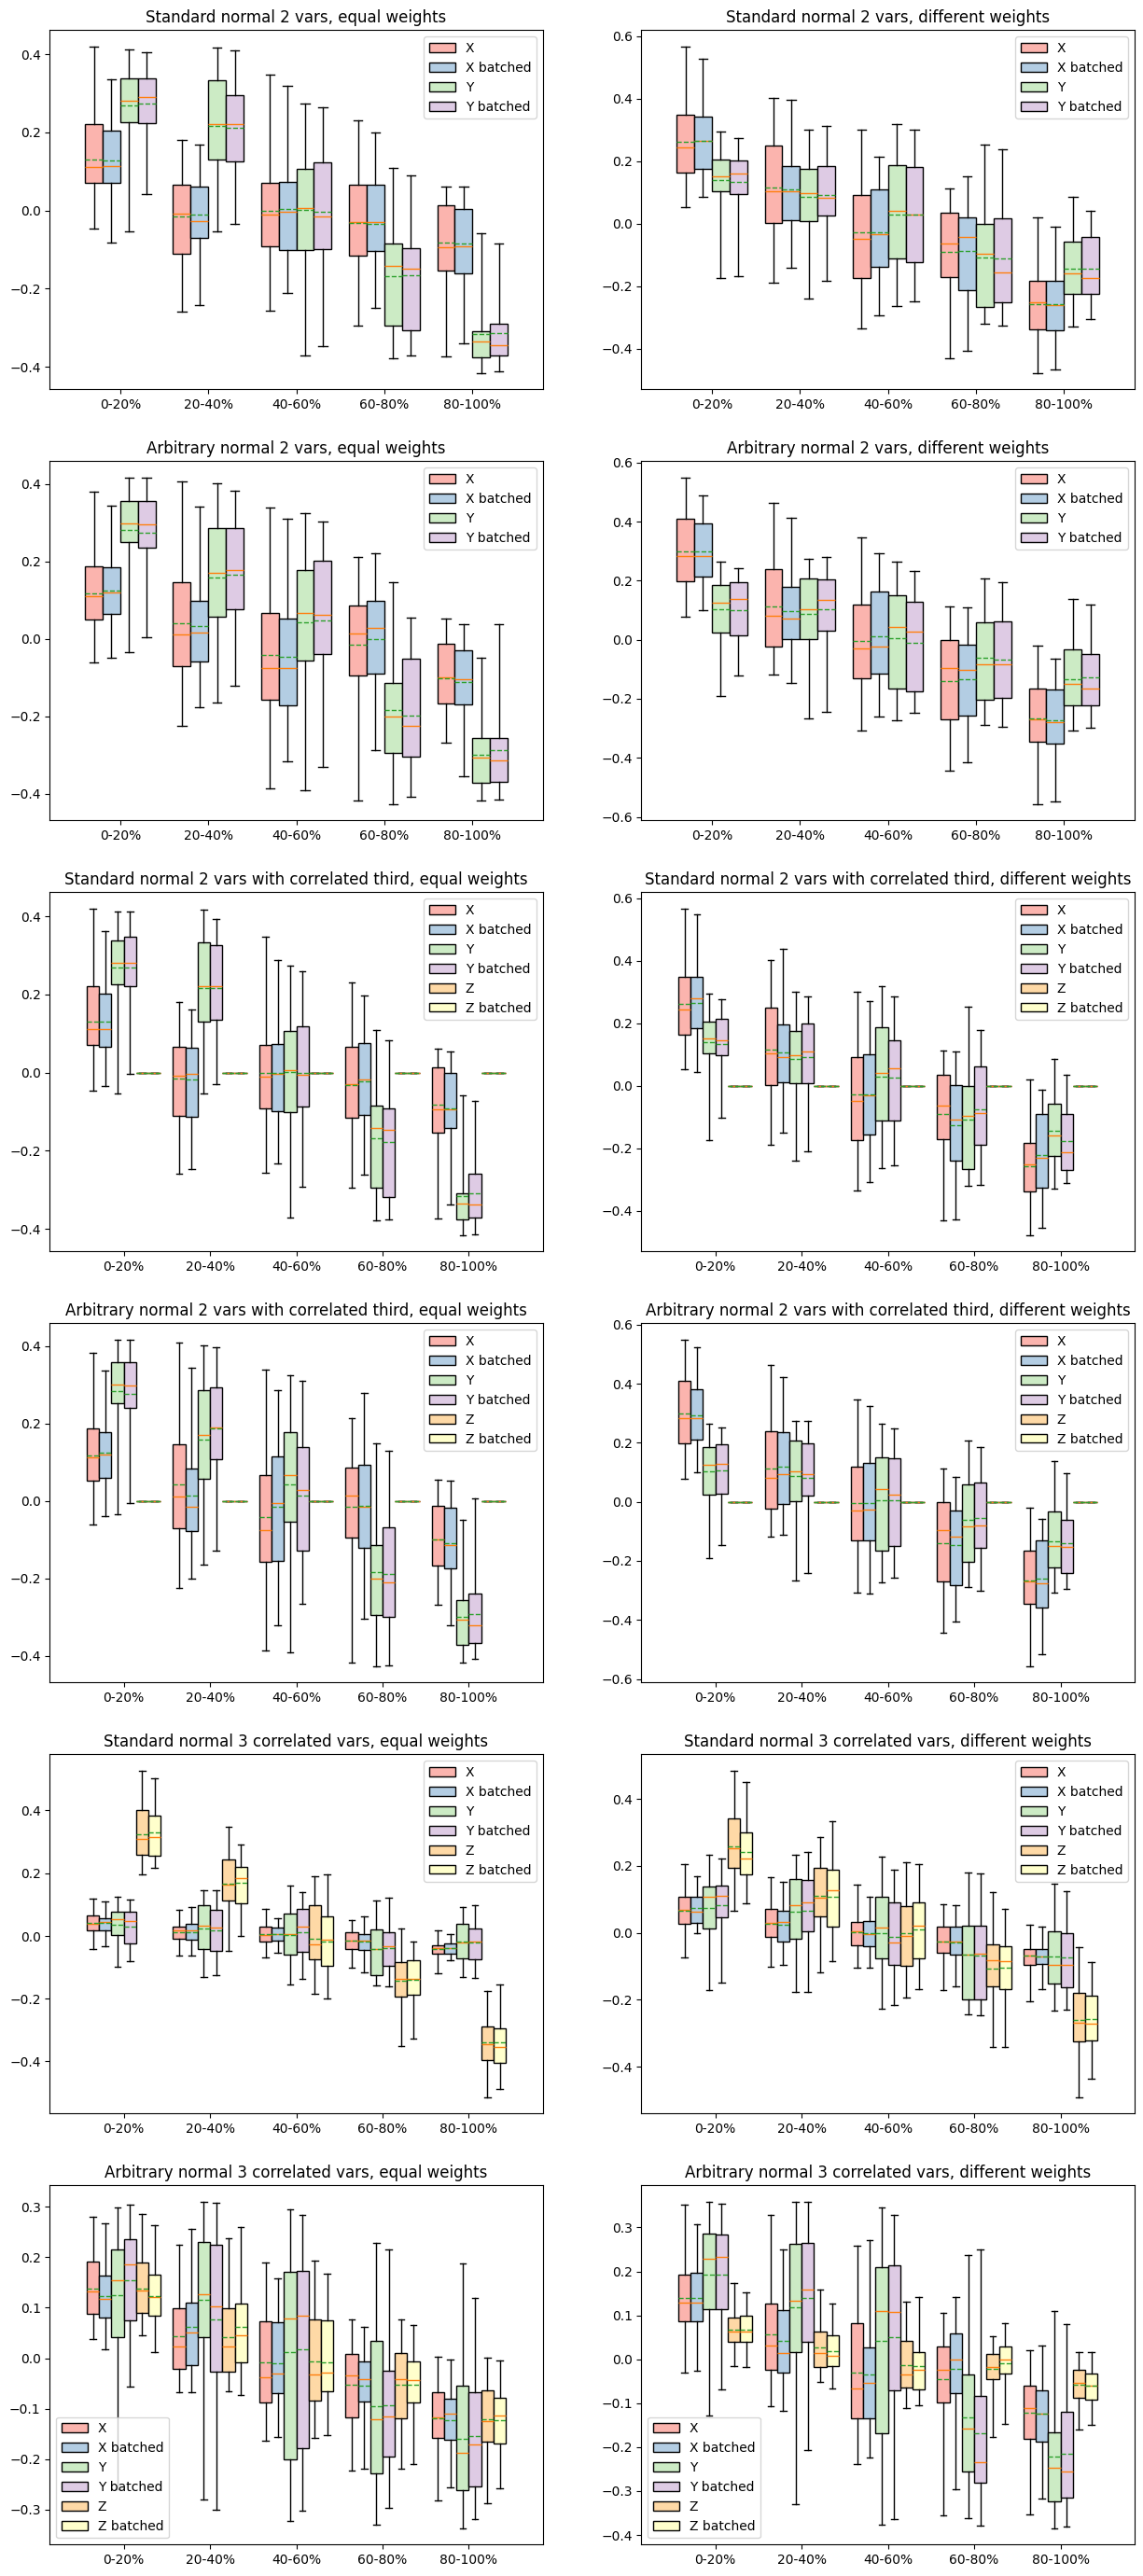

In [52]:
batched_figure = plot_statistics(plot_df.drop(columns=["batch", "qoi", "group"]))
batched_figure.savefig("batches_comparison.pdf")

In [54]:
statistics.to_csv("statistics.csv", index=False)

# Compare feature contributions

In [181]:
def inversions_count(arr1: list, arr2: list):
    indices = [arr1.index(x) for x in arr2]

    def merge_sort_inversions(arr):
        if len(arr) <= 1:
            return arr, 0
        else:
            a = arr[:len(arr) // 2]
            b = arr[len(arr) // 2:]
            a, ai = merge_sort_inversions(a)
            b, bi = merge_sort_inversions(b)
            c = []
            i = 0
            j = 0
            inversions = 0 + ai + bi
            while i < len(a) and j < len(b):
                if a[i] <= b[j]:
                    c.append(a[i])
                    i += 1
                else:
                    c.append(b[j])
                    j += 1
                    inversions += (len(a) - i)
            c += a[i:]
            c += b[j:]
        return c, inversions

    n = len(indices)
    return merge_sort_inversions(indices)[1] / (n * (n - 1)) * 2